### Importando Bibliotecas

In [50]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import os
from dotenv import load_dotenv
from matplotlib.dates import DayLocator
import matplotlib.pyplot as plt
import shap


In [2]:
## Importando variáveis
load_dotenv()

connUrl = URL.create(
    "mssql+pyodbc",
    host = os.environ.get('DB_HOST'),
    database = os.environ.get('DATABASE'),
    username = os.environ.get('DB_USR'),
    password = os.environ.get('DB_PASS'),
    query = {
        "driver": "ODBC Driver 18 for SQL Server",
        "TrustServerCertificate": "yes"      
    }
)

engine = create_engine(connUrl)

In [3]:
maquinas = pd.read_sql(
    """
    SELECT
         maquina,
         LEFT(rdt,10) AS data,
         eixo,
         torque,
         temperatura,
         vibracao
        FROM maquinas
        WHERE eixo <> 'Magazine' and eixo <> 'B'
        ORDER BY rdt ASC
    """,
    engine
)

### EDA

In [4]:
maquinas

,maquina,data,eixo,torque,temperatura,vibracao
0,M00432,2023-07-21,Spindle,7.537789,102.291122,2.121372
1,M00432,2023-07-21,X,3.054814,38.037018,1.025554
2,M00432,2023-07-21,Y,13.675704,54.596870,3.690912
3,M00432,2023-07-21,Z,4.122539,38.342598,1.176040
4,M00433,2023-07-21,Spindle,8.092338,91.643005,2.165652
...,...,...,...,...,...,...
29028,M00857,2025-08-23,Z,5.570493,43.797153,1.531150
29029,M00856,2025-08-23,Z,6.747095,46.270798,1.806726
29030,M00851,2025-08-23,Z,5.182936,44.389759,1.619674
29031,M00840,2025-08-23,Z,4.172271,41.188805,1.198877


In [5]:
maquinas.sort_values(by='data', ascending=False)

,maquina,data,eixo,torque,temperatura,vibracao
29032,M00838,2025-08-23,Z,3.582849,41.759354,1.118153
29022,M00838,2025-08-23,X,2.553402,38.610462,0.785732
29013,M00838,2025-08-23,Spindle,9.832145,78.141052,2.587028
29014,M00840,2025-08-23,Spindle,7.502781,87.152664,1.999276
29016,M00856,2025-08-23,Spindle,15.802381,64.045906,4.186075
...,...,...,...,...,...,...
4077,M00433,2023-07-21,X,1.847157,34.906696,0.605505
4078,M00433,2023-07-21,Y,13.761736,45.891499,3.728569
4079,M00433,2023-07-21,Z,3.957052,36.056087,1.170748
4080,M00434,2023-07-21,Spindle,5.929996,58.868668,1.595415


In [6]:
maquinas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29033 entries, 0 to 29032
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   maquina      29033 non-null  object 
 1   data         29033 non-null  object 
 2   eixo         29033 non-null  object 
 3   torque       29033 non-null  float64
 4   temperatura  29033 non-null  float64
 5   vibracao     29033 non-null  float64
dtypes: float64(3), object(3)
memory usage: 1.3+ MB


### Analise unidimensional das variáveis

In [7]:
## Frequência de máquinas

maquinas.maquina.value_counts()

maquina
M00442    1982
M00444    1982
M00451    1982
M00452    1982
M00433    1981
M00443    1981
M00432    1978
M00453    1978
M00456    1974
M00434    1890
M00836    1170
M00851    1165
M00857    1150
M00856    1062
M00838     945
M00839     943
M00837     942
M00853     667
M00854     667
M00840     612
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


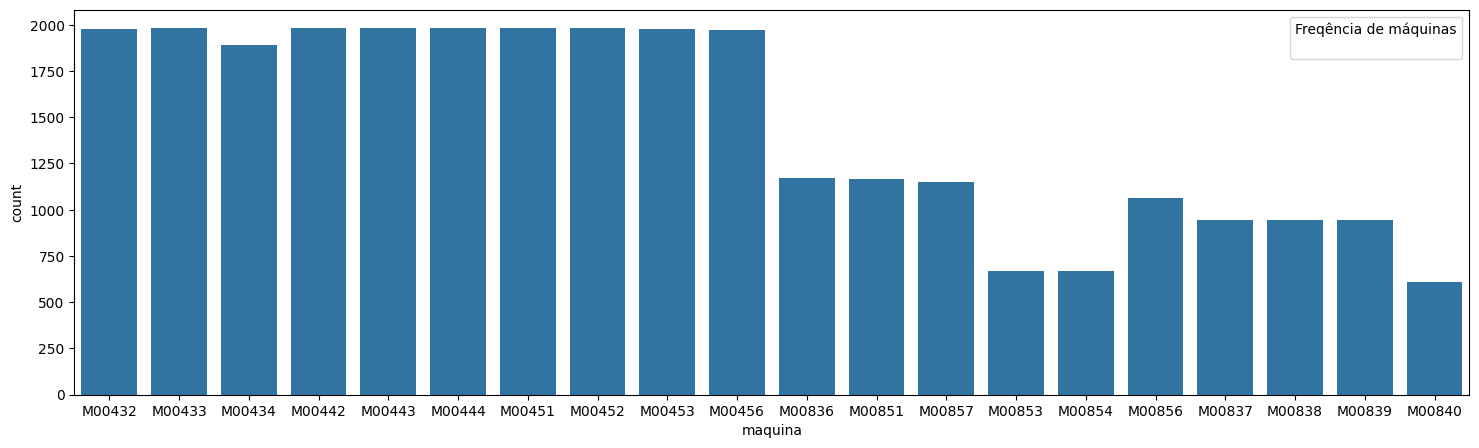

In [8]:
plt.figure(figsize=(18, 5))
sns.countplot(x='maquina', data=maquinas)
plt.legend(title='Freqência de máquinas', labelspacing=1.2)
plt.show()

In [9]:
### Analise de torque

maquinas.groupby('maquina')['torque'].mean()

maquina
M00432     6.835259
M00433     7.504227
M00434     8.292265
M00442     7.307244
M00443     6.000305
M00444     6.676351
M00451     6.547657
M00452     6.385699
M00453     7.337815
M00456     5.551252
M00836     6.737332
M00837     7.603891
M00838     6.336053
M00839     8.035822
M00840     6.783971
M00851     7.524691
M00853    10.158042
M00854     8.793099
M00856     8.727755
M00857    11.107080
Name: torque, dtype: float64

In [10]:
maquinas.torque.value_counts().sort_index

<bound method Series.sort_index of torque
2.235223    2
2.360094    2
2.481607    2
3.028734    2
2.508856    2
           ..
2.231138    1
3.012670    1
2.392274    1
2.050006    1
3.582849    1
Name: count, Length: 28985, dtype: int64>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


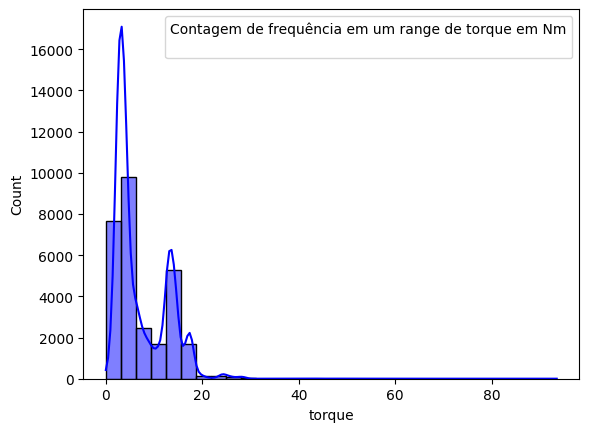

In [11]:
sns.histplot(maquinas, x='torque', bins=30, color='blue', kde=True, stat='count')
plt.legend(title='Contagem de frequência em um range de torque em Nm', labelspacing=1.2)
plt.show()

In [12]:
## Análise de vibração

maquinas.vibracao.value_counts().sort_index

<bound method Series.sort_index of vibracao
1.169198    3
0.917297    3
0.912233    2
1.117135    2
1.300533    2
           ..
3.623751    1
3.433895    1
3.404980    1
0.934932    1
1.118153    1
Name: count, Length: 28837, dtype: int64>

In [13]:
maquinas.groupby('maquina')['vibracao'].mean().sort_index

<bound method Series.sort_index of maquina
M00432    1.903076
M00433    2.080007
M00434    2.278921
M00442    2.053672
M00443    1.749321
M00444    1.887020
M00451    1.822875
M00452    1.798226
M00453    2.022102
M00456    1.602378
M00836    1.863937
M00837    2.072830
M00838    1.823078
M00839    2.169005
M00840    1.945198
M00851    2.094886
M00853    2.685958
M00854    2.380257
M00856    2.371570
M00857    2.972009
Name: vibracao, dtype: float64>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


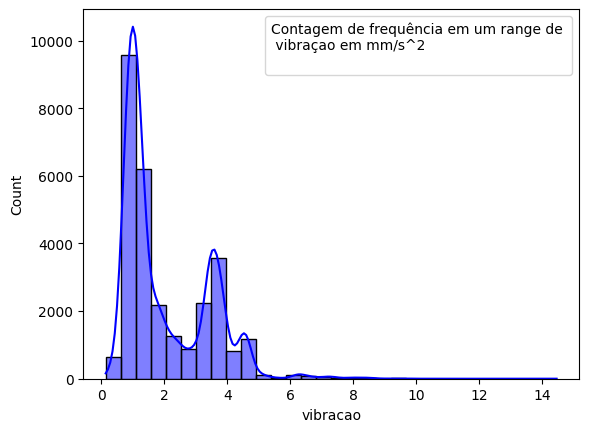

In [14]:
sns.histplot(maquinas, x='vibracao', bins=30, color='blue', kde=True, stat='count')
plt.legend(title='Contagem de frequência em um range de \n vibraçao em mm/s^2', labelspacing=1.2)
plt.show()

In [15]:
## Analise de temperatura

maquinas.temperatura.value_counts().sort_index

<bound method Series.sort_index of temperatura
0.000000     107
36.284245      2
50.350693      2
39.079914      2
40.773697      2
            ... 
38.901363      1
40.909393      1
35.456383      1
38.992165      1
41.759354      1
Name: count, Length: 28865, dtype: int64>

In [16]:
maquinas.groupby('maquina')['temperatura'].mean()

maquina
M00432    53.055046
M00433    50.302164
M00434    46.851870
M00442    44.701756
M00443    46.132807
M00444    47.860671
M00451    42.800241
M00452    47.080827
M00453    44.913679
M00456    45.207107
M00836    51.434979
M00837    50.813630
M00838    48.063921
M00839    53.539780
M00840    52.744975
M00851    56.151855
M00853    54.459572
M00854    60.390175
M00856    51.565814
M00857    57.953275
Name: temperatura, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


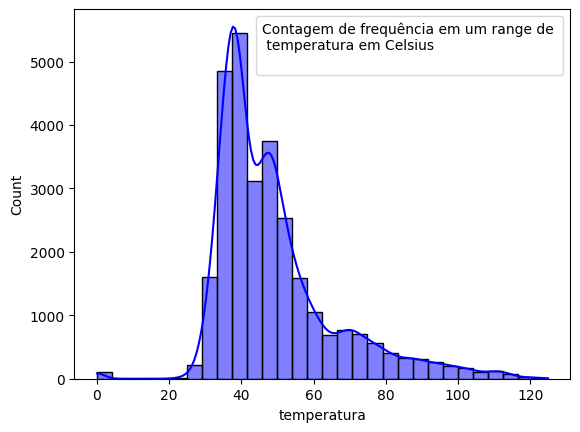

In [17]:
sns.histplot(maquinas, x='temperatura', bins=30, color='blue', kde=True, stat='count')
plt.legend(title='Contagem de frequência em um range de \n temperatura em Celsius', labelspacing=1.2)
plt.show()

In [18]:
### Resumo geral das variáveis

maquinas.drop(columns=['maquina', 'data','eixo']).describe()

,torque,temperatura,vibracao
count,29033.000000,29033.000000,29033.000000
mean,7.266839,49.043373,2.020315
std,5.528162,16.623711,1.370443
min,0.035858,0.000000,0.140439
25%,3.094008,37.746037,0.975532
50%,4.455795,44.840908,1.315359
75%,12.644730,54.374744,3.349643
max,93.507751,124.907913,14.451904


### Analise de correlação das variáveis

In [19]:
colunas_corr = maquinas[['torque', 'temperatura', 'vibracao']]
colunas_corr

,torque,temperatura,vibracao
0,7.537789,102.291122,2.121372
1,3.054814,38.037018,1.025554
2,13.675704,54.596870,3.690912
3,4.122539,38.342598,1.176040
4,8.092338,91.643005,2.165652
...,...,...,...
29028,5.570493,43.797153,1.531150
29029,6.747095,46.270798,1.806726
29030,5.182936,44.389759,1.619674
29031,4.172271,41.188805,1.198877


In [20]:
matriz_corr = colunas_corr.corr()
print(matriz_corr)

               torque  temperatura  vibracao
torque       1.000000     0.457309  0.930654
temperatura  0.457309     1.000000  0.451999
vibracao     0.930654     0.451999  1.000000


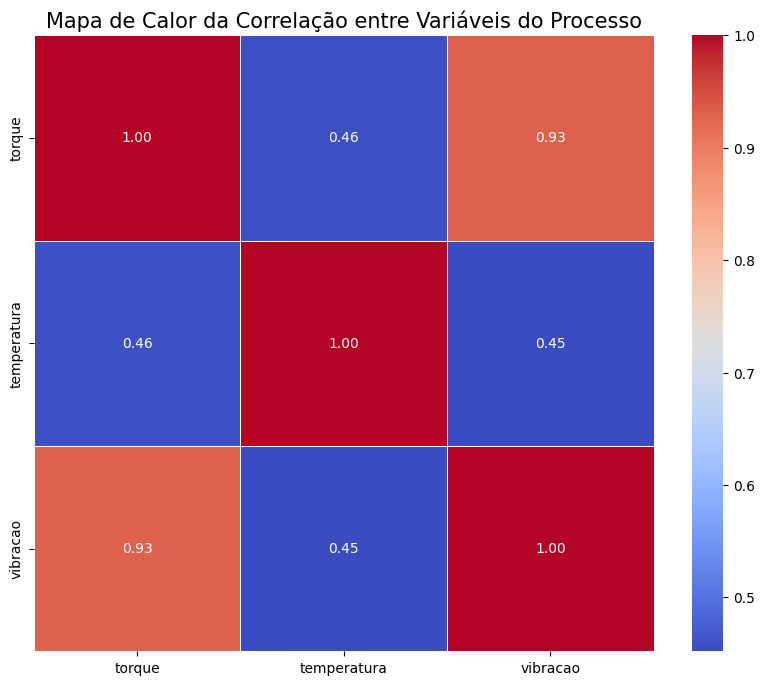

In [21]:
### Exibição gráfica do resultado da matriz em heatmap

plt.figure(figsize=(10,8))
sns.heatmap(
    matriz_corr,
    annot=True,       
    cmap='coolwarm',  
    fmt=".2f",        
    linewidths=.5
)
plt.title('Mapa de Calor da Correlação entre Variáveis do Processo', fontsize=15)
plt.show()

Além da correlação positiva entre torque e vibração.

É possível observar uma grande anomalia entre a faixa 0-20 de torque, bem como um ponto disperso alto do esforço da máquina de +80.

E uma vibração desproporcional a partir de "40nm"m em que o equipamento se torna mais instável a partir dessa faixa.

### Análise de outliers com o boxplot

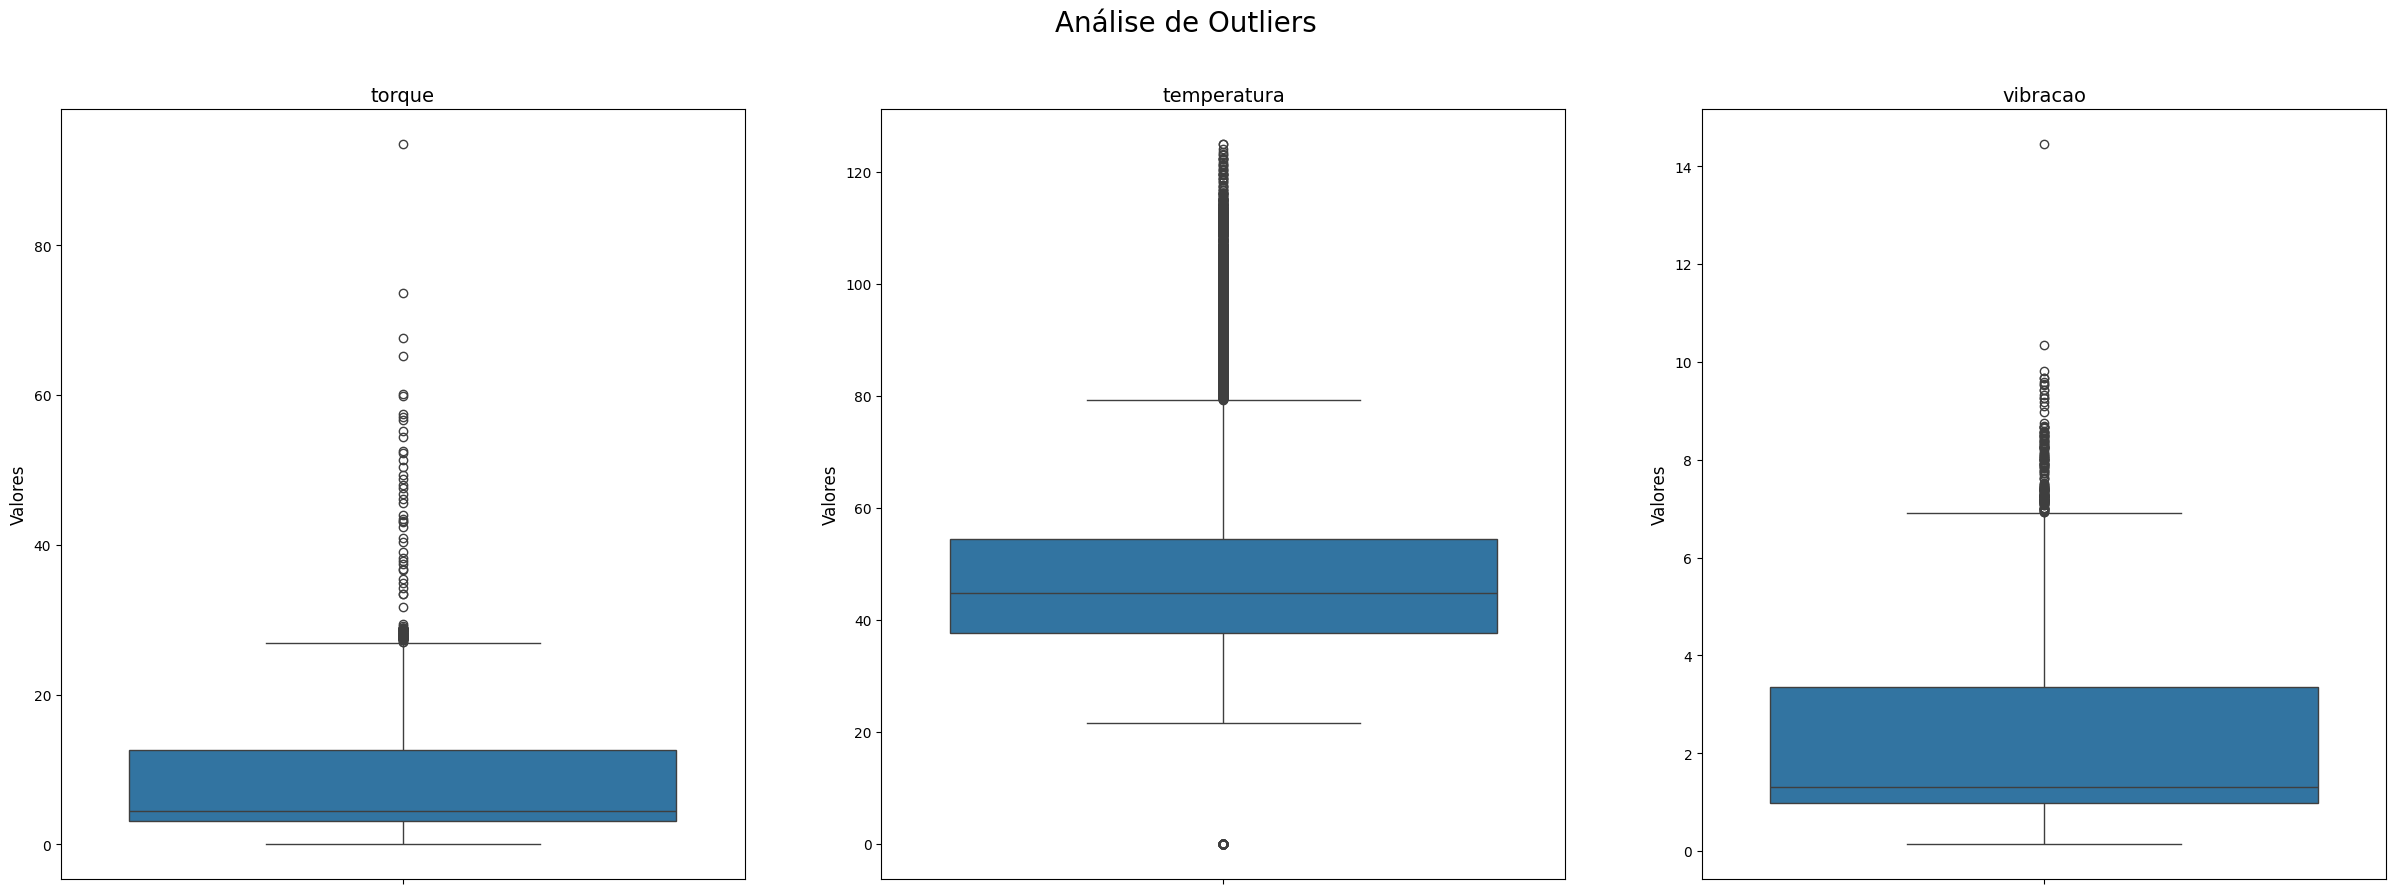

In [22]:
variaveis = ['torque', 'temperatura', 'vibracao']

fig, axes = plt.subplots(1, 3, figsize=(30, 10))

axes = axes.flatten()

fig.suptitle('Análise de Outliers', fontsize=20)

for i, coluna in enumerate(variaveis):
    sns.boxplot(y=colunas_corr[coluna], ax=axes[i], orient='v')
    axes[i].set_title(f'{coluna}', fontsize=14)
    axes[i].set_ylabel('Valores', fontsize=12)
    axes[i].set_xlabel('')

### Análise das variáveis categóricas de data e eixos pela relação Torque vs. Vibração

Essa análise irá permitir a visualização da evolução do desempenho da máquina ao londo do tempo. Com isso, iremos detectar a degradação. A vibração para o mesmo nível de torque está
aumentando com o passar dos dias, semanas e meses?

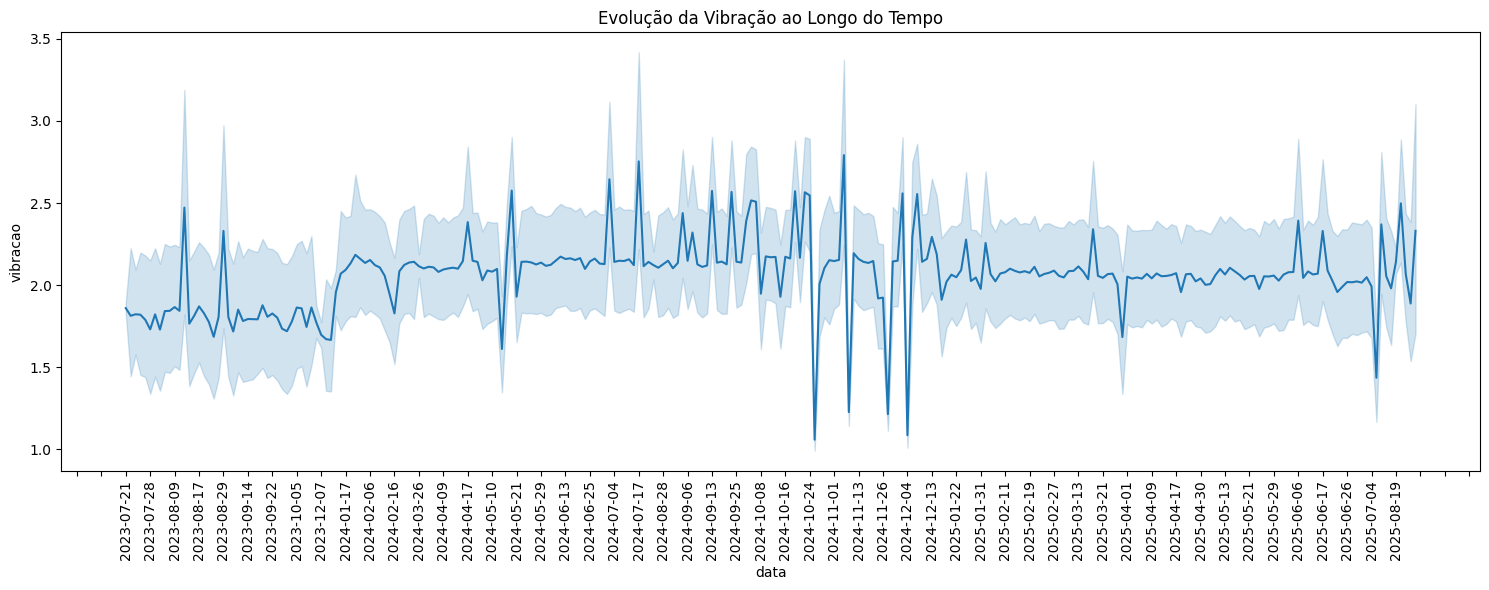

In [23]:
# Analisando a vibração ao longo do tempo

plt.figure(figsize=(15, 6))
ax = sns.lineplot(data=maquinas, x='data', y='vibracao')
plt.title('Evolução da Vibração ao Longo do Tempo')

## Formatando o eixo X para ficar mais visível

plt.xticks(rotation=90)
ax.xaxis.set_major_locator(DayLocator(interval=5))
plt.tight_layout() 
plt.show()

É nítido que os maiores picos de vibração ocorreram entre "30-10-2024" e "06-12-2024"

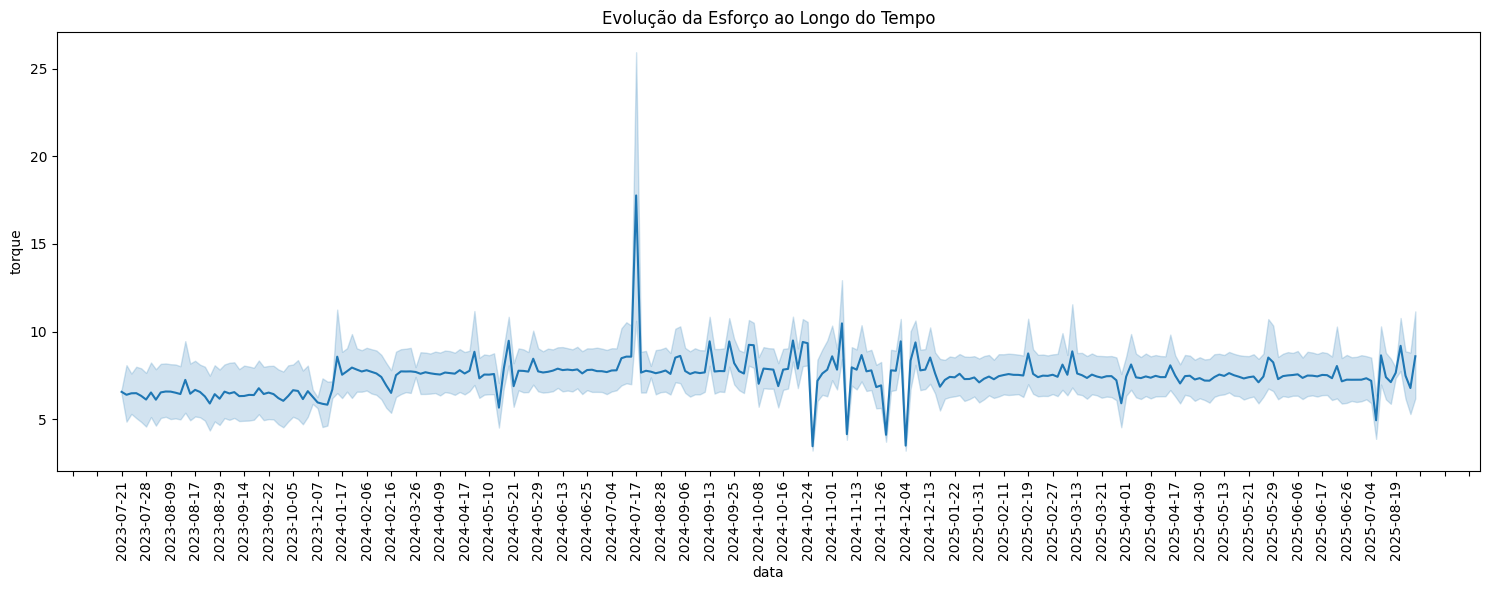

In [24]:
# Análise de torque da máquina

plt.figure(figsize=(15, 6))
ax = sns.lineplot(data=maquinas, x='data', y='torque')
plt.title('Evolução da Esforço ao Longo do Tempo')

## Formatando o eixo X para ficar mais visível

plt.xticks(rotation=90)
ax.xaxis.set_major_locator(DayLocator(interval=5))
plt.tight_layout() 
plt.show()

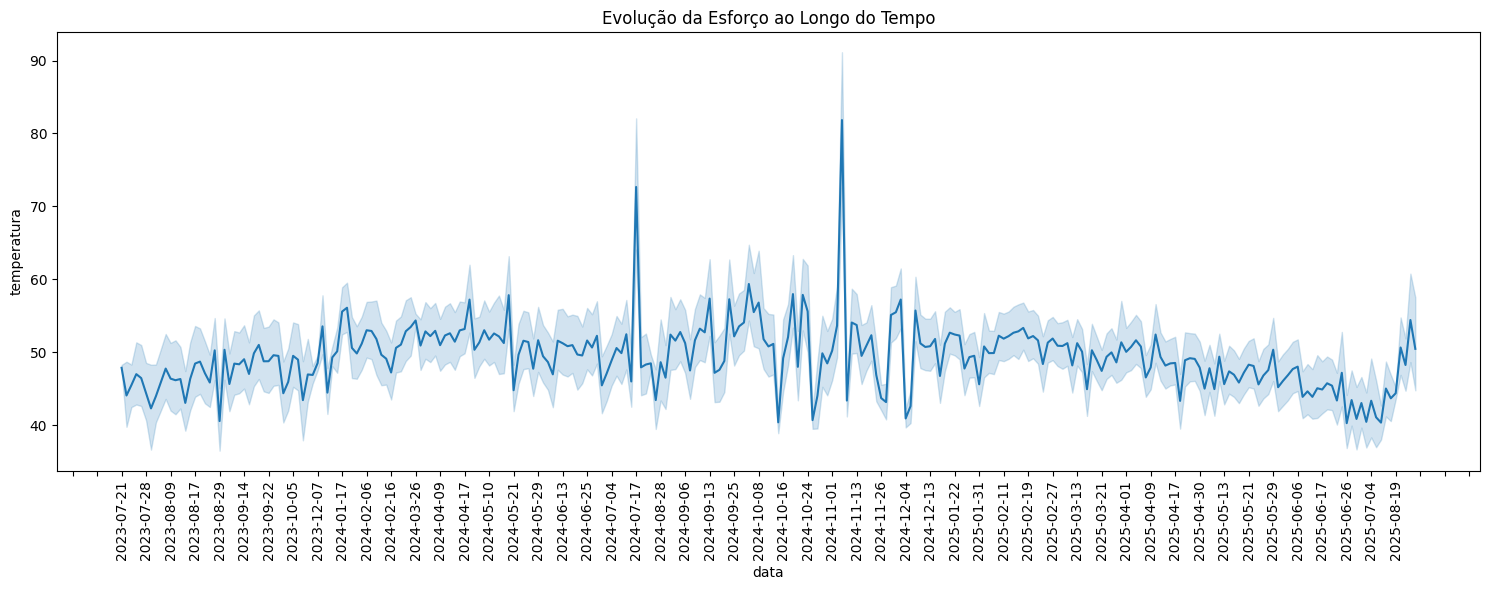

In [25]:
# Análise de temperatura da máquina

plt.figure(figsize=(15, 6))
ax = sns.lineplot(data=maquinas, x='data', y='temperatura')
plt.title('Evolução da Esforço ao Longo do Tempo')

## Formatando o eixo X para ficar mais visível

plt.xticks(rotation=90)
ax.xaxis.set_major_locator(DayLocator(interval=5))
plt.tight_layout() 
plt.show()

### Validação de hipótese de esforço e vibração dos eixos

Segundo o PCM e operadores, o eixo que mais exerce esforço para a usinagem do bloco é o X.

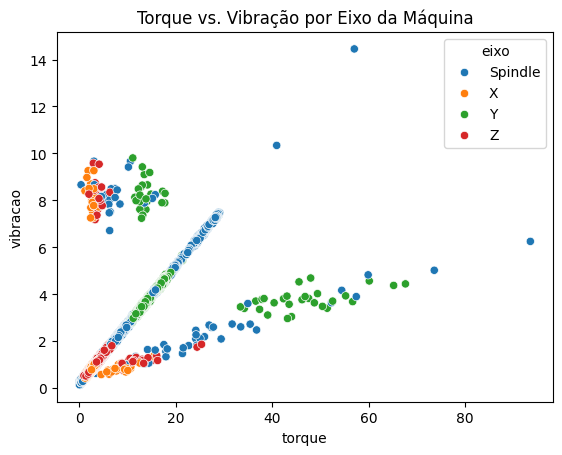

In [26]:
## Qual eixo exerce mais esforço vs. vibração?

sns.scatterplot(data=maquinas, x='torque', y='vibracao', hue='eixo')
plt.title('Torque vs. Vibração por Eixo da Máquina')
plt.show()

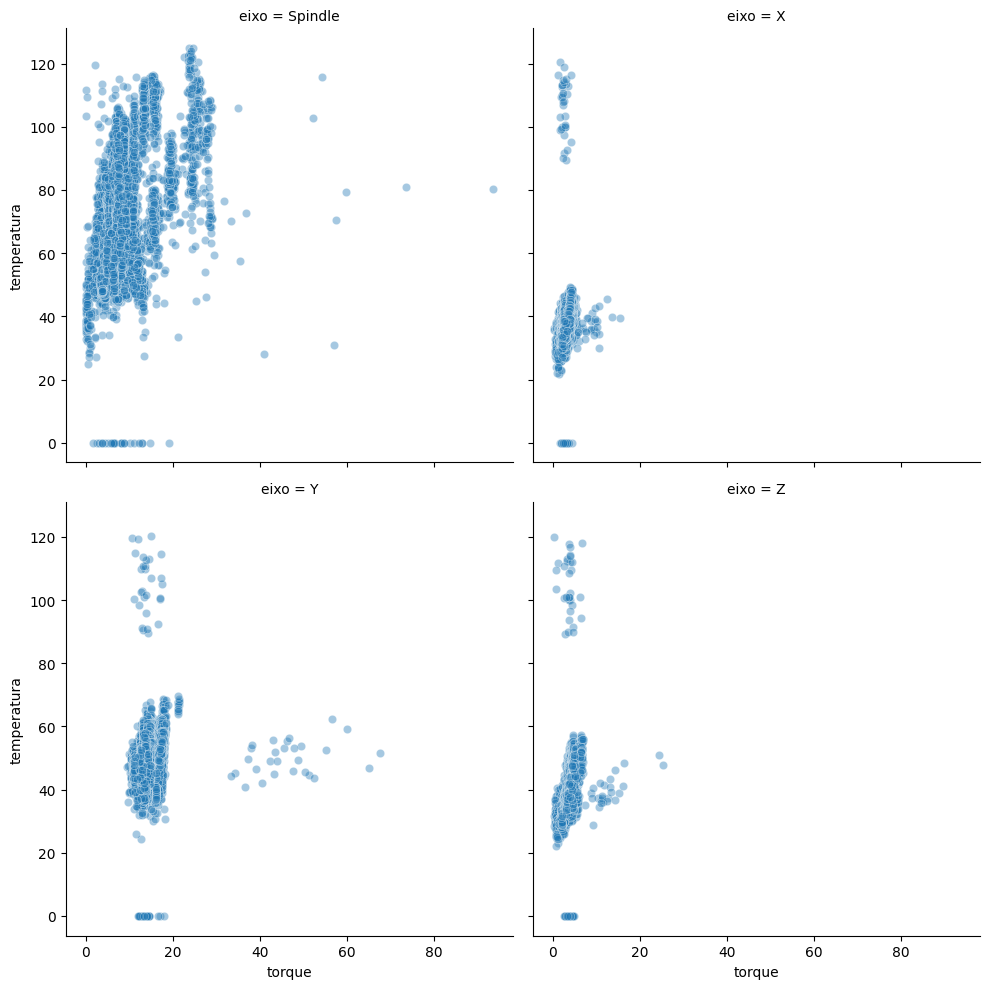

In [27]:
sns.relplot(data=maquinas, 
            x='torque', 
            y='temperatura', 
            col='eixo',        
            col_wrap=2, 
            alpha=0.4)    

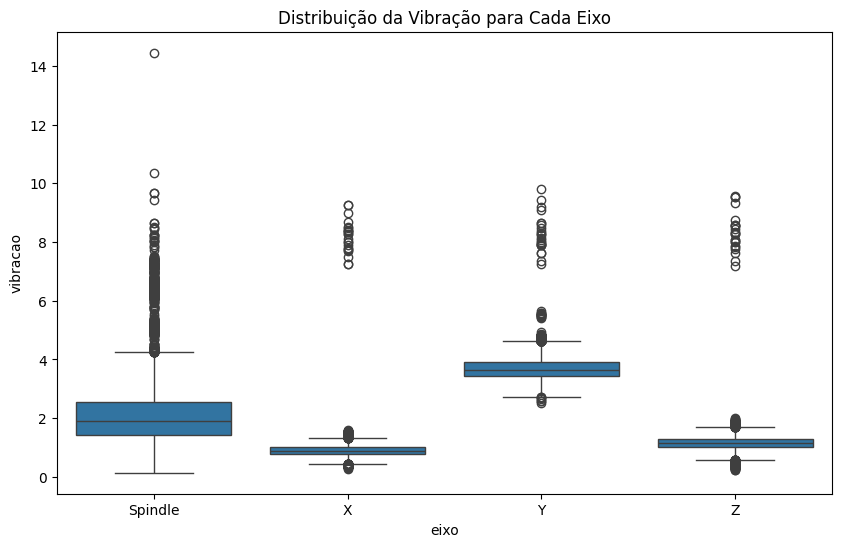

In [28]:
## Comparando distribuição. Qual eixo vibra mais, em média?

plt.figure(figsize=(10, 6))
sns.boxplot(data=maquinas, x='eixo', y='vibracao')
plt.title('Distribuição da Vibração para Cada Eixo')
plt.show()

Aqui concluímos que a maior vibração típica ocorre no eixo Y. Entretando, o spindle é o que mais sofre com eventos extremos de vibração.

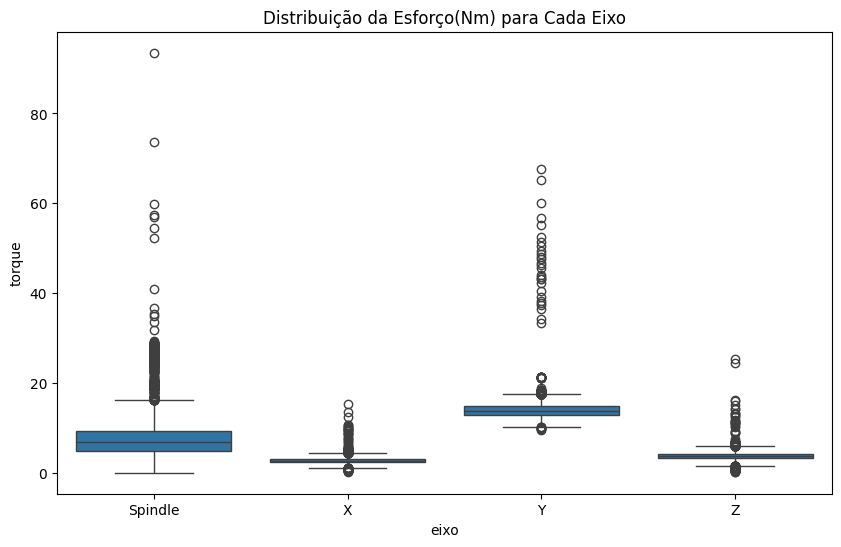

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=maquinas, x='eixo', y='torque')
plt.title('Distribuição da Esforço(Nm) para Cada Eixo')
plt.show()

É possível observar uma similaridade com o gráfico de vibração. Assim como o primeiro gráfico, concluímos que o eixo Y opera em esforço maior parte do tempo. Entretanto, é o spindle que se destaca com eventos extremos.

Isso sugere uma forte relação de causa e efeito: os picos de vibração que vimos antes no Spindle são muito provavelmente causados por estes picos de torque (ou ocorrem simultaneamente). 
Quando o Spindle precisa realizar um esforço súbito e extremo (como no início de um corte, por exemplo), ele vibra violentamente.

### Construção do modelo de detecção de anomalia

In [30]:
from pycaret.anomaly import *

In [31]:
s = setup(data = maquinas,
          normalize = True,
          #session_id=123,
          log_data=False)

,Description,Value
0,Session id,2987
1,Original data shape,"(29033, 6)"
2,Transformed data shape,"(29033, 292)"
3,Numeric features,3
4,Categorical features,3
5,Preprocess,True
6,Imputation type,simple
7,Numeric imputation,mean
8,Categorical imputation,mode
9,Maximum one-hot encoding,-1


In [32]:
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pycaret.internal.patches.pyod.CBLOFForceToDouble
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


### Algoritmo Isolation Forest

In [33]:
# Compara todos os modelos e armazena os 5 melhores em uma variável
iforest = create_model('iforest')

In [34]:
print(iforest)

IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=2987, verbose=0)


In [35]:
iforest_resultado = assign_model(iforest)

In [36]:
iforest_resultado.head(10).sort_values(by='Anomaly_Score', ascending=False)

,maquina,data,eixo,torque,temperatura,vibracao,Anomaly,Anomaly_Score
0,M00432,2023-07-21,Spindle,7.537789,102.291122,2.121372,1,0.002007
4,M00433,2023-07-21,Spindle,8.092338,91.643005,2.165652,0,-0.006096
2,M00432,2023-07-21,Y,13.675704,54.596870,3.690912,0,-0.009036
8,M00434,2023-07-21,Spindle,6.473615,49.998821,1.805127,0,-0.012117
9,M00434,2023-07-21,X,5.487844,42.013634,1.568211,0,-0.012618
3,M00432,2023-07-21,Z,4.122539,38.342598,1.176040,0,-0.014139
1,M00432,2023-07-21,X,3.054814,38.037018,1.025554,0,-0.015144
7,M00433,2023-07-21,Z,4.728767,37.026051,1.437108,0,-0.015413
6,M00433,2023-07-21,Y,15.041248,49.128780,3.908612,0,-0.017715
5,M00433,2023-07-21,X,2.258934,37.753071,0.924431,0,-0.019353


In [37]:
iforest_resultado.Anomaly.value_counts()

Anomaly
0    27581
1     1452
Name: count, dtype: int64

In [38]:
anomalias = iforest_resultado.query('Anomaly == 1').sort_values(by='Anomaly_Score', ascending=False)
anomalias

,maquina,data,eixo,torque,temperatura,vibracao,Anomaly,Anomaly_Score
18713,M00851,2024-10-10,Spindle,13.446760,106.350708,3.614009,1,0.019689
10398,M00853,2024-02-06,Spindle,19.813129,80.733505,5.177051,1,0.018099
18714,M00853,2024-10-10,Spindle,19.406544,91.350746,5.134121,1,0.017718
10397,M00851,2024-02-06,Spindle,11.980038,103.602798,3.194341,1,0.017232
8648,M00851,2023-12-07,Spindle,0.602280,51.747349,0.371291,1,0.016957
...,...,...,...,...,...,...,...,...
18409,M00453,2024-10-02,X,3.108738,41.963829,0.921627,1,0.000029
8761,M00452,2023-12-07,X,1.646196,36.697868,0.616171,1,0.000029
3562,M00434,2023-07-21,Y,60.115597,59.195873,4.569316,1,0.000013
10386,M00442,2024-02-06,Spindle,5.931669,45.624184,1.662741,1,0.000008


In [39]:
iforest_resultado.groupby('Anomaly')['torque'].describe()

,count,mean,std,min,25%,50%,75%,max
Anomaly,,,,,,,,
0,27581.0,7.205912,5.452514,0.039673,3.093368,4.421915,12.598293,93.507751
1,1452.0,8.424172,6.705194,0.035858,3.107684,7.020656,12.995889,60.115597


In [40]:
iforest_resultado.groupby('Anomaly')['vibracao'].describe()

,count,mean,std,min,25%,50%,75%,max
Anomaly,,,,,,,,
0,27581.0,2.003739,1.351857,0.140439,0.975230,1.305335,3.337215,9.808367
1,1452.0,2.335184,1.654294,0.152244,0.983385,1.978310,3.466785,14.451904


In [41]:
anomalias.sort_values(by='Anomaly_Score', ascending=False).head(10)

,maquina,data,eixo,torque,temperatura,vibracao,Anomaly,Anomaly_Score
18713,M00851,2024-10-10,Spindle,13.446760,106.350708,3.614009,1,0.019689
10398,M00853,2024-02-06,Spindle,19.813129,80.733505,5.177051,1,0.018099
18714,M00853,2024-10-10,Spindle,19.406544,91.350746,5.134121,1,0.017718
10397,M00851,2024-02-06,Spindle,11.980038,103.602798,3.194341,1,0.017232
8648,M00851,2023-12-07,Spindle,0.602280,51.747349,0.371291,1,0.016957
8532,M00851,2023-12-07,Spindle,0.488356,53.420025,0.325801,1,0.016957
8324,M00851,2023-12-07,Spindle,1.432733,51.794415,0.526781,1,0.016957
8584,M00851,2023-12-07,Spindle,0.572706,48.849819,0.409150,1,0.016957
8956,M00851,2023-12-07,Spindle,0.838391,46.609531,0.377360,1,0.016957
8376,M00851,2023-12-07,Spindle,0.937359,52.423065,0.383743,1,0.016957


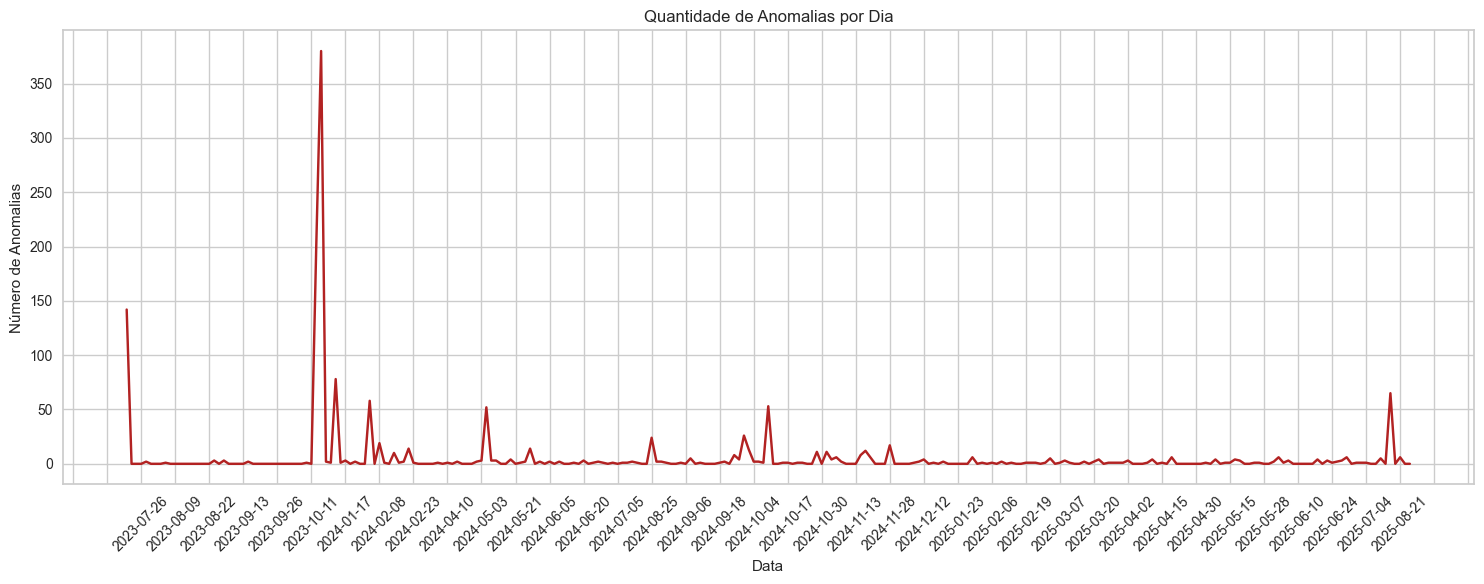

In [42]:
contagem_diaria = anomalias.groupby('data').size().reset_index(name='quantidade')

plt.figure(figsize=(15, 6))

ax = sns.lineplot(data=contagem_diaria, x='data', y='quantidade', color='firebrick')
plt.title('Quantidade de Anomalias por Dia')
plt.xlabel('Data')
plt.ylabel('Número de Anomalias')


plt.xticks(rotation=45) 
ax.xaxis.set_major_locator(DayLocator(interval=7))
plt.tight_layout() 
plt.show()

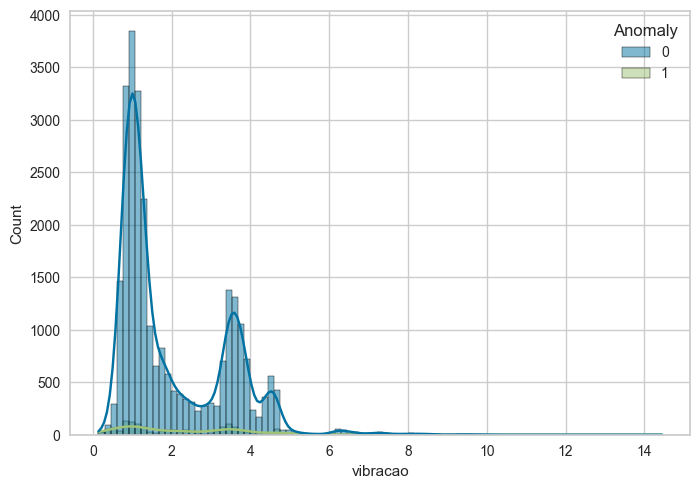

In [43]:
sns.histplot(data=iforest_resultado, x='vibracao', kde=True, hue='Anomaly', fill=True)
plt.show()

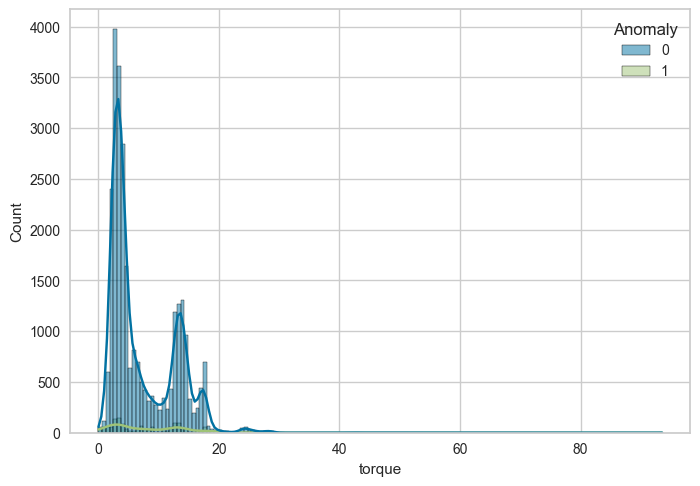

In [44]:
sns.histplot(data=iforest_resultado, x='torque', kde=True, hue='Anomaly', fill=True)
plt.show()

<Axes: xlabel='torque', ylabel='vibracao'>

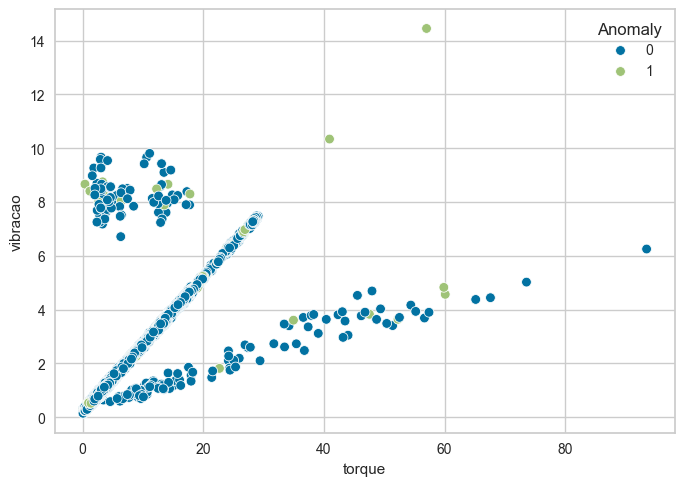

In [45]:
sns.scatterplot(data=iforest_resultado, x='torque', y='vibracao', hue='Anomaly')

<Axes: xlabel='torque', ylabel='vibracao'>

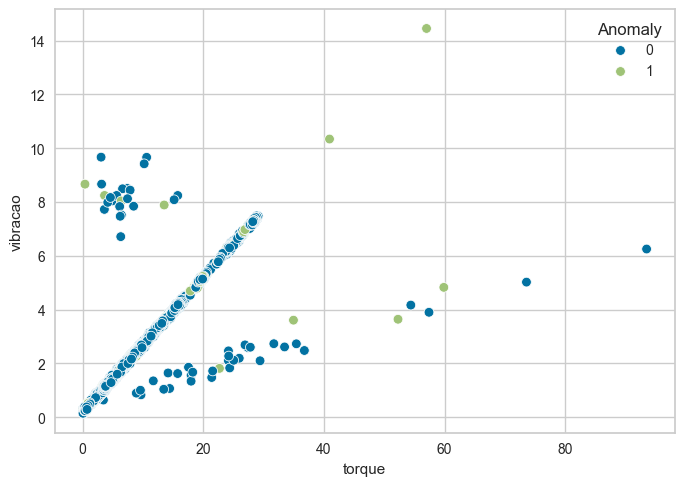

In [46]:
sns.scatterplot(data=iforest_resultado.query('eixo == "Spindle"'), x='torque', y='vibracao', hue='Anomaly')

<Axes: xlabel='torque', ylabel='vibracao'>

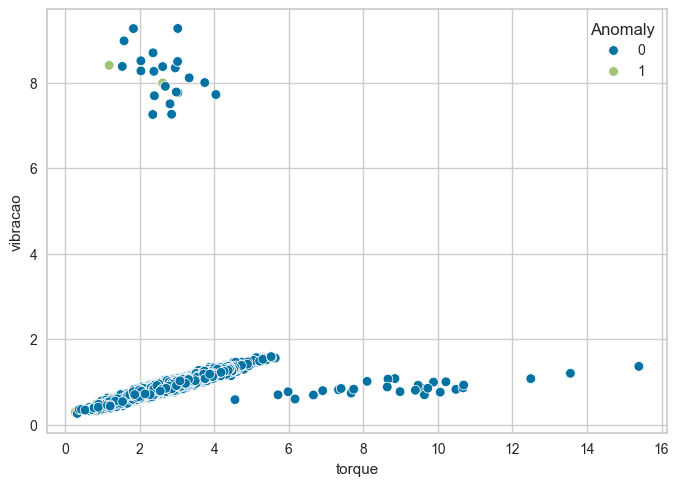

In [47]:
sns.scatterplot(data=iforest_resultado.query('eixo == "X"'), x='torque', y='vibracao', hue='Anomaly')

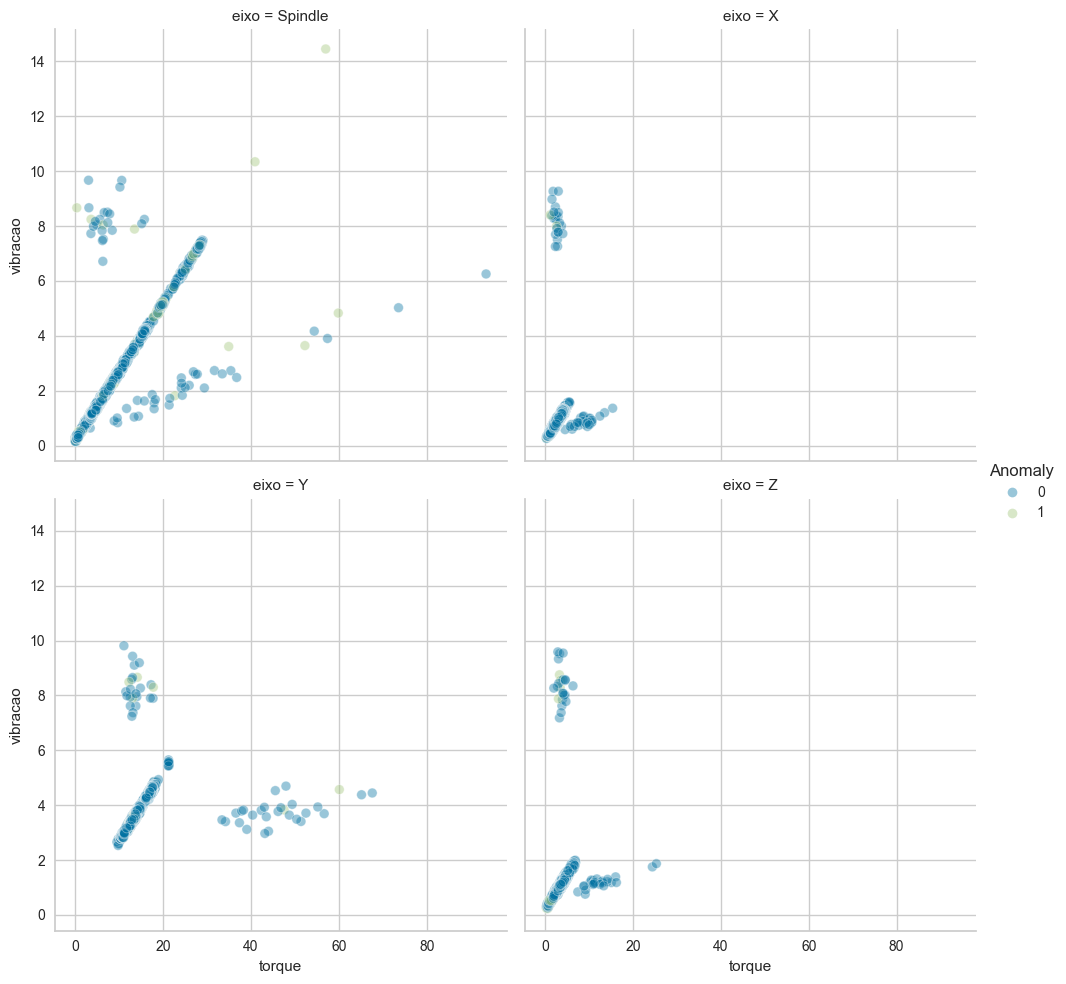

In [48]:
sns.relplot(data=iforest_resultado, 
            x='torque', 
            y='vibracao', 
            col='eixo',
            hue='Anomaly' ,     
            col_wrap=2, 
            alpha=0.4)    